# Option Pricing: Asian options and Temperature Derivatives

### Job Marcelis, Ernani Hazbolatow, Koen Verlaan
#### May 2025, University of Amsterdam

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.Euler_vs_Milstein import *
from src.control_variate_MC import *

import pandas as pd
from src.weather_derivatives import *
import openmeteo_requests
import requests_cache
from retry_requests import retry

#### Asian options under the Heston model

In [2]:
# Model parameters
S0 = 100
V0 = 0.04
K = 105
T = 1
dt = 0.001
r = 0.05
rho = -0.7
kappa = 2
theta = 0.04
xi = 0.25
M = 10000
seed = 69
sigma = 0.2

First, we compare the Euler and Milstein discretization schemes:

In [3]:
dts = np.logspace(-5, -1, 15)
eul_means = np.zeros_like(dts)
eul_CI = np.zeros_like(dts)
mil_means = np.zeros_like(dts)
mil_CI = np.zeros_like(dts)
for i, dt in enumerate(dts):
    MC_est_euler, MC_est_euler_CI, MC_est_mil, MC_est_mil_CI = heston_euler_vs_milstein(M, S0, V0, K, T, dt, r, rho, kappa, theta, xi, seed)
    eul_means[i] = MC_est_euler
    eul_CI[i] = MC_est_euler_CI
    mil_means[i] = MC_est_mil
    mil_CI[i] = MC_est_mil_CI

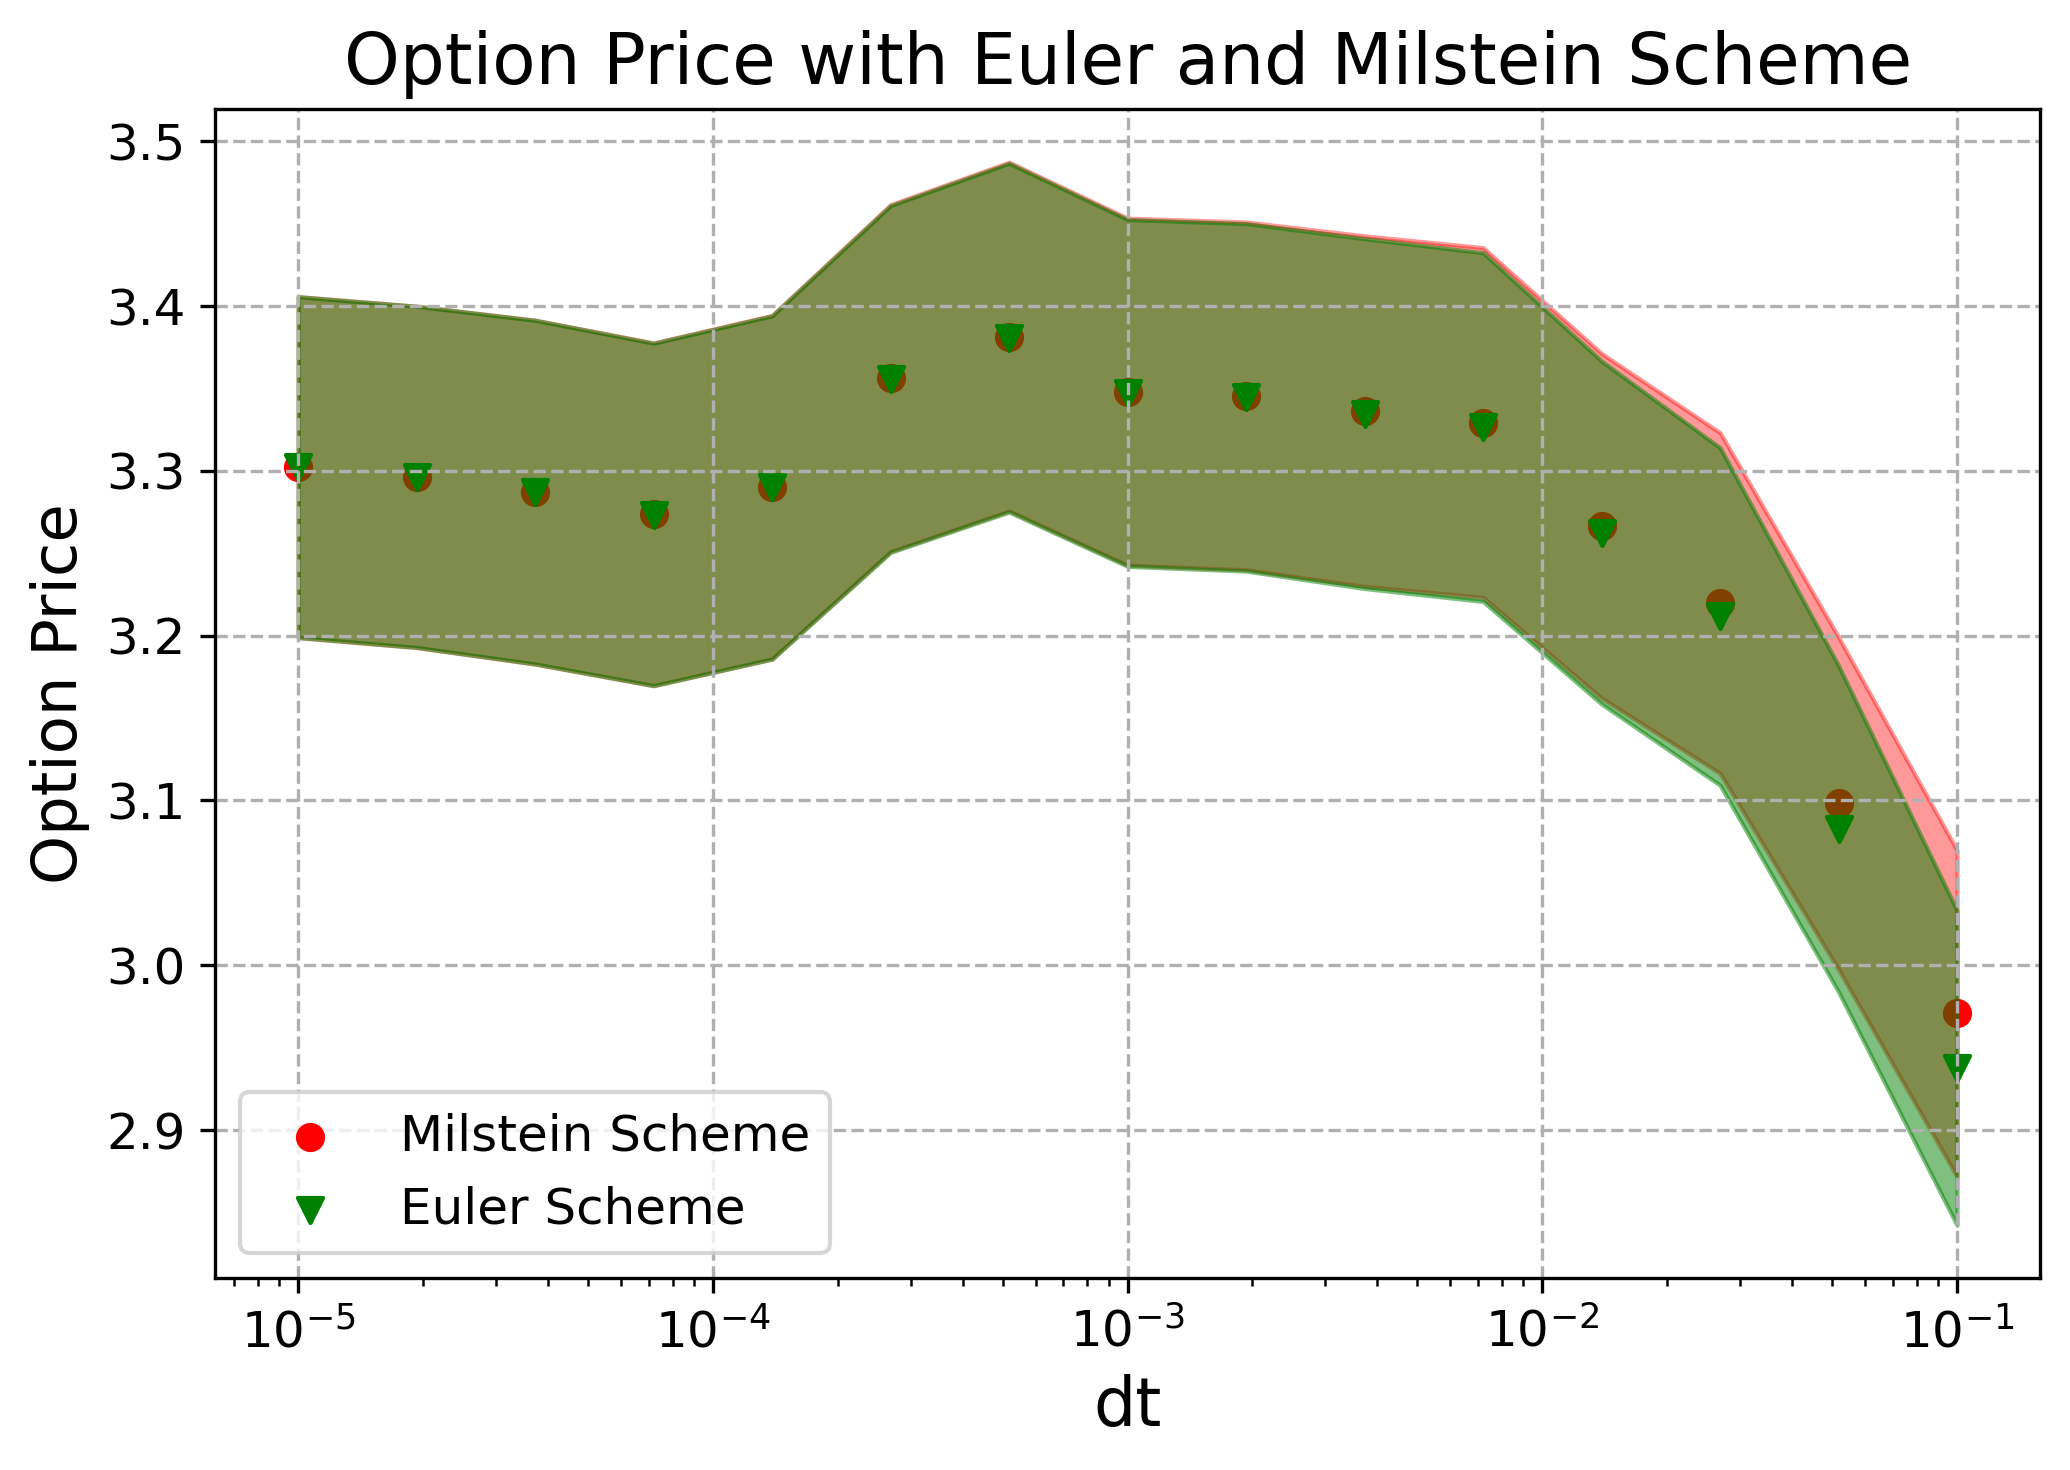

In [4]:
plt.figure(figsize=(7,5), dpi=300)
plt.title('Option Price with Euler and Milstein Scheme', fontsize=17)
plt.scatter(dts, mil_means, color='red', label='Milstein Scheme')
plt.fill_between(dts, mil_means - mil_CI, mil_means + mil_CI, alpha=0.4, color='red')
plt.scatter(dts, eul_means, color='green', label='Euler Scheme', marker='v')
plt.fill_between(dts, eul_means - eul_CI, eul_means + eul_CI, alpha=0.5, color='green')
plt.xlabel('dt', fontsize=16)
plt.ylabel('Option Price', fontsize=15)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.grid(ls='dashed')
plt.xscale('log')
plt.tight_layout()
plt.show()

To verify our implementation, we set $\xi = 0$ and compare it to a geometric Brownian motion benchmark:

In [5]:
dt = 0.0001
MC_est_euler, MC_est_euler_CI, MC_est_mil, MC_est_mil_CI = heston_euler_vs_milstein(M, S0, V0, K, T, dt, r, rho, kappa, theta, 0, seed)
GBM_mean, GBM_CI = gbm_benchmark(M, S0, K, T, dt, r, sigma, seed)
print(f'Euler (xi=0) price = {MC_est_euler} +- {MC_est_euler_CI}')
print(f'Milstein (xi=0) price = {MC_est_mil} +- {MC_est_mil_CI}')
print(f'GBM price = {GBM_mean} +- {GBM_CI}')

Euler (xi=0) price = 3.4728090955333566 +- 0.12384594080102712
Milstein (xi=0) price = 3.4728612669021226 +- 0.12385837082191851
GBM price = 3.5066653963268326 +- 0.12413679334492515


From now on, we use $\Delta t = 10^{-4}$ and the control variate coefficient is set to $c=1$.

In [6]:
dt = 0.0001
sigma = 0.2
c = 1
M = 100000

The control variate that is used is the analytical geometric Asian price, which we compare to the previous results to ensure accuracy:

In [7]:
analyt_price = analytical_price(S0, r, T, K, sigma, int(T/dt))
print(f'Control Variate reference (sigma = 0.2, N = 10000, c = 1) = {analyt_price}')
MC_est_euler, MC_est_euler_CI, MC_est_mil, MC_est_mil_CI = heston_euler_vs_milstein(10000, S0, V0, K, T, dt, r, rho, kappa, theta, xi, seed)
print(f'Euler price = {MC_est_euler} +- {MC_est_euler_CI}')
print(f'Milstein price = {MC_est_mil} +- {MC_est_mil_CI}')

Control Variate reference (sigma = 0.2, N = 10000, c = 1) = 3.324930090012195
Euler price = 3.269184295084294 +- 0.10368912676560699
Milstein price = 3.269373761511992 +- 0.10370139519034206


Now, we do the first control variate run and compare the prices, standard error, and variance of plain Monte carlo and control variate Monte Carlo

In [8]:
result_singleM = control_variate_MC(M, S0, V0, K, T, dt, r, rho, kappa, theta, xi, sigma, c, seed)

In [9]:
print(f"Plain Monte Carlo price = {result_singleM['plain'][0]}. StdErr = {result_singleM['plain'][1]} and Var = {result_singleM['plain'][2]}")
print(f"CV Monte Carlo price = {result_singleM['control_var'][0]}. StdErr = {result_singleM['control_var'][1]} and Var = {result_singleM['control_var'][2]}")

Plain Monte Carlo price = 3.3251064776491153. StdErr = 0.01702125658261376 and Var = 28.972317565117237
CV Monte Carlo price = 3.3014480574031126. StdErr = 0.006099743377938309 and Var = 3.720686927670225


To investigate the efficacy of the variance reduction, we use multiple numbers of paths ($M$):

In [10]:
for i, M_paths in enumerate([10000, 50000, 100000, 150000, 200000, 250000]):
    result = control_variate_MC(M_paths, S0, V0, K, T, dt, r, rho, kappa, theta, xi, sigma, c, seed*2+i)
    print(f'M = {M_paths} paths')
    print(f"Plain Monte Carlo price = {result['plain'][0]}. StdErr = {result['plain'][1]} and Var = {result['plain'][2]}")
    print(f"CV Monte Carlo price = {result['control_var'][0]}. StdErr = {result['control_var'][1]} and Var = {result['control_var'][2]}")
    print('===============================================================================================================')

M = 10000 paths
Plain Monte Carlo price = 3.3137138244803768. StdErr = 0.05324911199732615 and Var = 28.354679285037832
CV Monte Carlo price = 3.3206684001763582. StdErr = 0.01907464991035969 and Var = 3.6384226920278495
M = 50000 paths
Plain Monte Carlo price = 3.2875627139418566. StdErr = 0.02393610451739176 and Var = 28.646854973375113
CV Monte Carlo price = 3.3135054944529356. StdErr = 0.008479050663011222 and Var = 3.5947150072955534
M = 100000 paths
Plain Monte Carlo price = 3.307552187330767. StdErr = 0.017038555675528918 and Var = 29.031237950809878
CV Monte Carlo price = 3.3165097701299104. StdErr = 0.006097263235933098 and Var = 3.717661896826136
M = 150000 paths
Plain Monte Carlo price = 3.3141905963784852. StdErr = 0.01386808456637606 and Var = 28.84856543102368
CV Monte Carlo price = 3.304369560567973. StdErr = 0.004993454526147815 and Var = 3.7401882157059148
M = 200000 paths
Plain Monte Carlo price = 3.3277444327736787. StdErr = 0.012086401925797357 and Var = 29.21622230

We also want to know the impact on the prices and standard errors when varying some Heston parameters. Below we vary $\xi$, $\rho$, and $K$ independently.

In [11]:
plain_price_xi, plain_std_xi, cv_price_xi, cv_std_xi, xis = heston_sensitivity(M, S0, V0, K, T, dt, r, rho, kappa, theta, xi, sigma, c, seed, parameter_to_vary='xi')

In [12]:
plain_price_rho, plain_std_rho, cv_price_rho, cv_std_rho, rhos = heston_sensitivity(M, S0, V0, K, T, dt, r, rho, kappa, theta, xi, sigma, c, seed, parameter_to_vary='rho')

In [13]:
plain_price_k, plain_std_k, cv_price_k, cv_std_k, ks = heston_sensitivity(M, S0, V0, K, T, dt, r, rho, kappa, theta, xi, sigma, c, seed, parameter_to_vary='K')

In [14]:
def print_results(plain_prices, plain_stds, cv_prices, cv_stds):
    for i in range(len(plain_prices)):
        print(f'Plain MC price = {plain_prices[i]} +- {plain_stds[i]}')
        print(f'Control Variate prices = {cv_prices[i]} +- {cv_stds[i]}')
        print(f'Improvement stderr = {plain_stds[i] / cv_stds[i]}')
        print('===========================')

# print_results(plain_price_xi, plain_std_xi, cv_price_xi, cv_std_xi)
# print_results(plain_price_rho, plain_std_rho, cv_price_rho, cv_std_rho)
print_results(plain_price_k, plain_std_k, cv_price_k, cv_std_k)

Plain MC price = 9.00250452103024 +- 0.02672847862023334
Control Variate prices = 8.972711464855442 +- 0.006961936248755456
Improvement stderr = 3.83923059120391
Plain MC price = 7.306165993046385 +- 0.024574043501141365
Control Variate prices = 7.277919739903549 +- 0.006807194036639379
Improvement stderr = 3.6100107281903253
Plain MC price = 5.783819259717342 +- 0.0221944590111895
Control Variate prices = 5.757032697320809 +- 0.006609783402956398
Improvement stderr = 3.357819410733255
Plain MC price = 4.45343577656214 +- 0.019650142178831025
Control Variate prices = 4.427660569059517 +- 0.006369553149354937
Improvement stderr = 3.0850111017318462
Plain MC price = 3.3251064776491153 +- 0.01702125658261376
Control Variate prices = 3.3014480574031126 +- 0.006099743377938309
Improvement stderr = 2.7904873251187308


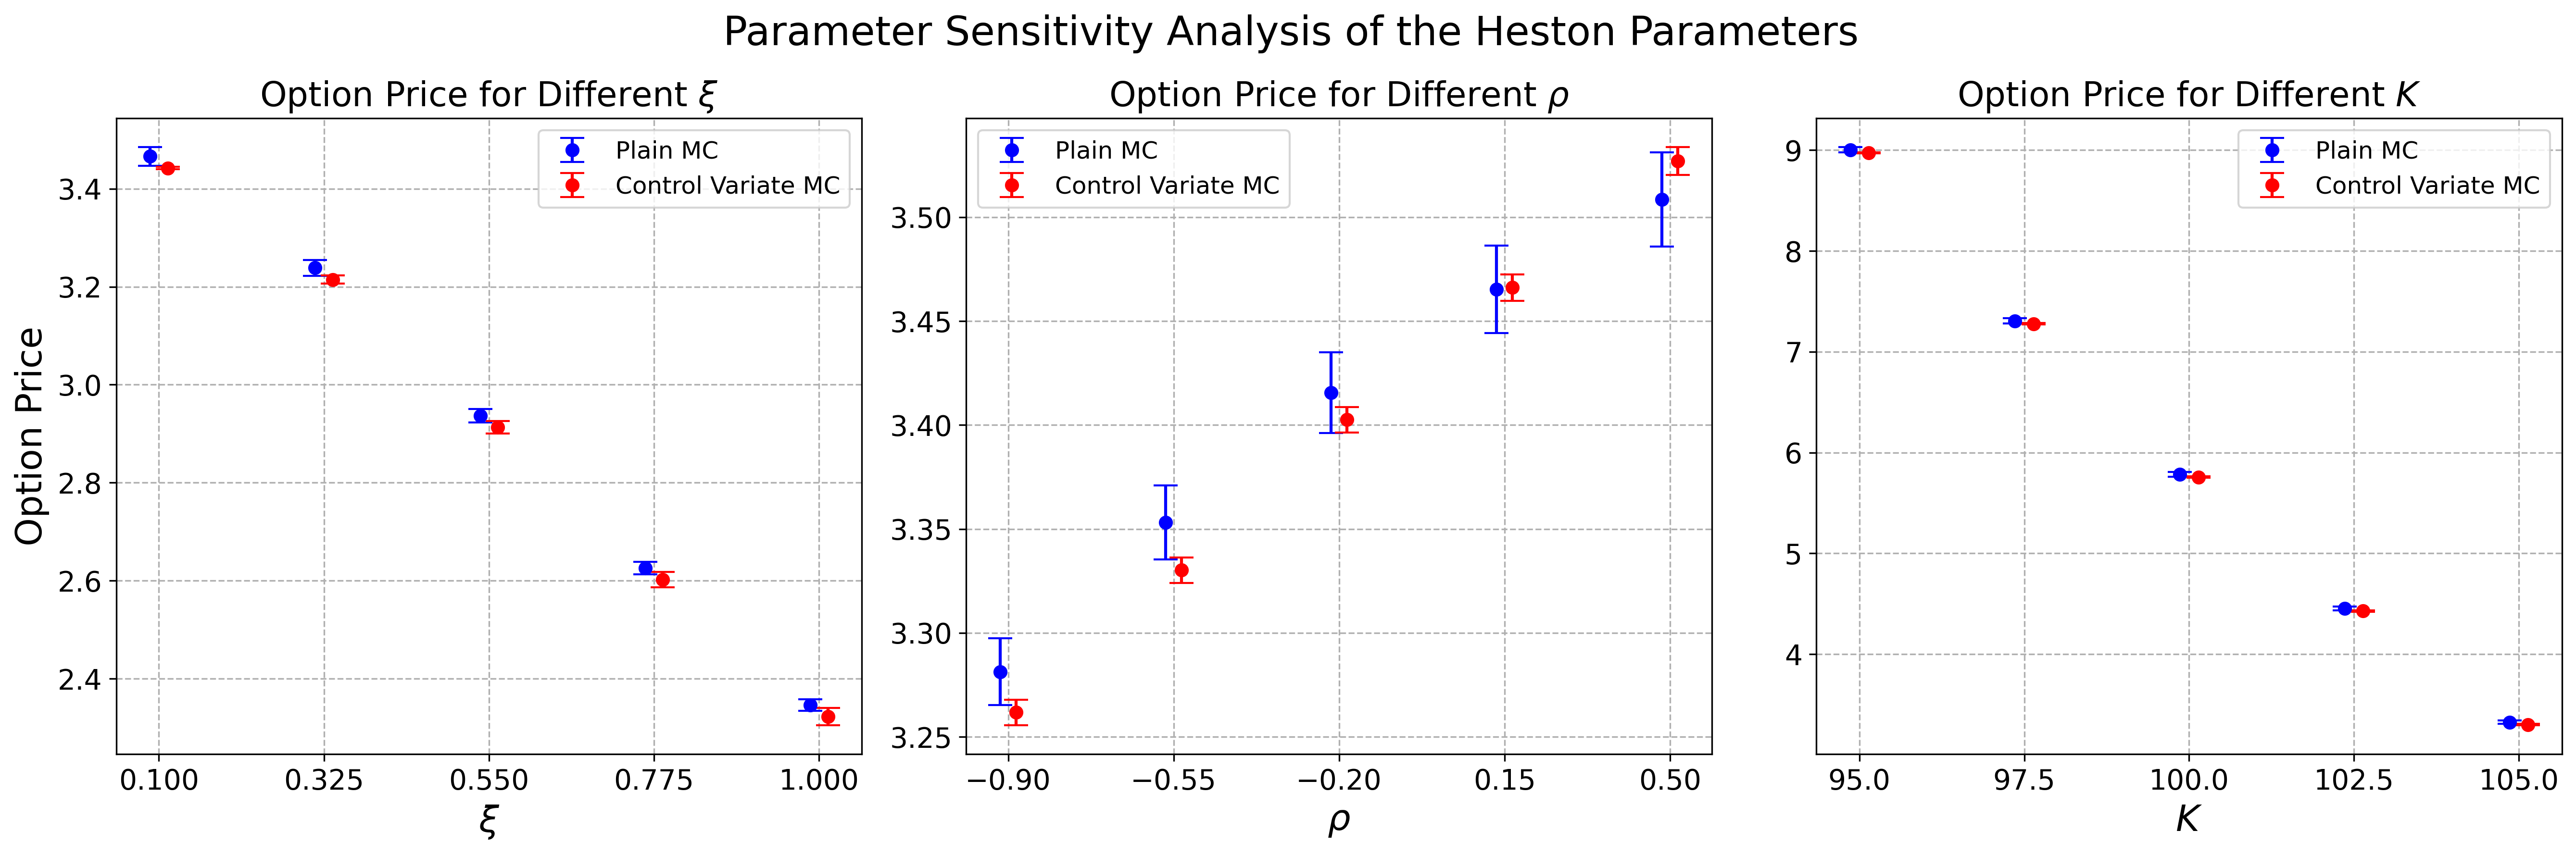

In [15]:
plt.figure(figsize=(18, 6), dpi=300)
plt.suptitle('Parameter Sensitivity Analysis of the Heston Parameters', fontsize=20)
plt.subplot(1, 3, 1)
plt.title(r'Option Price for Different $\xi$', fontsize=17)
plt.errorbar([xi - 0.012 for xi in xis], plain_price_xi, yerr=plain_std_xi, fmt='o', color='blue', label='Plain MC', capsize=6)
plt.errorbar([xi + 0.012 for xi in xis], cv_price_xi, yerr=cv_std_xi, fmt='o', color='red', label='Control Variate MC', capsize=6)
plt.ylabel('Option Price', fontsize=18)
plt.xlabel(r'$\xi$', fontsize=18)
plt.xticks(xis)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=12)
plt.grid(ls='dashed')

plt.subplot(1, 3, 2)
plt.title(r'Option Price for Different $\rho$', fontsize=17)
plt.errorbar([rho - 0.017 for rho in rhos], plain_price_rho, yerr=plain_std_rho, fmt='o', color='blue', label='Plain MC', capsize=6)
plt.errorbar([rho + 0.017 for rho in rhos], cv_price_rho, yerr=cv_std_rho, fmt='o', color='red', label='Control Variate MC', capsize=6)
plt.xlabel(r'$\rho$', fontsize=18)
plt.xticks(rhos)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=12)
plt.grid(ls='dashed')

plt.subplot(1, 3, 3)
plt.title(r'Option Price for Different $K$', fontsize=17)
plt.errorbar([k - 0.14 for k in ks], plain_price_k, yerr=plain_std_k, fmt='o', color='blue', label='Plain MC', capsize=6)
plt.errorbar([k + 0.14 for k in ks], cv_price_k, yerr=cv_std_k, fmt='o', color='red', label='Control Variate MC', capsize=6)
plt.xlabel(r'$K$', fontsize=18)
plt.xticks(ks)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=12)
plt.grid(ls='dashed')

plt.tight_layout()
plt.show()

Lastly, to gain better performance, we estimate the optimal value for the control variate coefficient.

In [16]:
result = control_variate_MC(M, S0, V0, K, T, dt, r, rho, kappa, theta, xi, sigma, c, seed)

In [17]:
opt_c = optimal_c(result['payoffs'][1], result['payoffs'][0])
print(f'The optimal values for c is c* = {opt_c}')

The optimal values for c is c* = 0.833005335005508


In [18]:
result_singleM_opt_c = control_variate_MC(M, S0, V0, K, T, dt, r, rho, kappa, theta, xi, sigma, opt_c, seed)

In [19]:
print(f"Plain Monte Carlo price = {result_singleM_opt_c['plain'][0]}. StdErr = {result_singleM_opt_c['plain'][1]} and Var = {result_singleM_opt_c['plain'][2]}")
print(f"CV Monte Carlo price = {result_singleM_opt_c['control_var'][0]}. StdErr = {result_singleM_opt_c['control_var'][1]} and Var = {result_singleM_opt_c['control_var'][2]}")

Plain Monte Carlo price = 3.3251064776491153. StdErr = 0.01702125658261376 and Var = 28.972317565117237
CV Monte Carlo price = 3.305398887366393. StdErr = 0.005160765365250161 and Var = 2.6633499155165627


## 3. Weather Derivatives

In this part we'll be handling part 3 of the assignment: pricing weather derivatives based on the Heating Degree Days (HDD) for Amsterdam.

First, we'll be getting the data through the Open-Meteo API to fetch historical temperature data for Amsterdam. The data covers 2018-2024 and will be used to calibrate our pricing model.

In [3]:
# Setup API client with caching
cache_session = requests_cache.CachedSession(".openmeteo_cache", expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Query parameters for Amsterdam
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 52.37,
    "longitude": 4.89,
    "start_date": "2018-01-01",
    "end_date": "2024-12-31",
    "daily": "temperature_2m_mean",
    "timezone": "Europe/Amsterdam",
}

# Fetch and process data
response = openmeteo.weather_api(url, params=params)[0]
daily = response.Daily()
temp_np = daily.Variables(0).ValuesAsNumpy()

dates_idx = pd.date_range(
    start=pd.Timestamp(daily.Time(), unit="s", tz="UTC")
          .tz_convert("Europe/Amsterdam")
          .normalize(),
    periods=len(temp_np),
    freq="D"
)

df = (
    pd.DataFrame({"T_mean": temp_np}, index=dates_idx)
      .asfreq("D")
      .interpolate(limit_direction="both")
)

df.head()

,T_mean
2017-12-31 00:00:00+01:00,6.644667
2018-01-01 00:00:00+01:00,5.842583
2018-01-02 00:00:00+01:00,8.013415
2018-01-03 00:00:00+01:00,7.678000
2018-01-04 00:00:00+01:00,6.513416


Now we'll calibrate our temperature model using the historical data.
The model includes:
- Seasonal mean μ̄(t)
- Mean reversion rate κ
- Seasonal volatility σ(t)

In [10]:
model = calibrate_from_data(df)

print("Model calibration results:")
print(f"Mean temperature (a): {model.a:.2f}°C")
print(f"Linear trend (b): {model.b*365.25:.3f}°C/year")  # convert to annual rate
print(f"Seasonal amplitude: {np.sqrt(model.a1**2 + model.b1**2):.2f}°C")
print(f"Mean reversion (κ): {model.kappa:.3f} day⁻¹")

Model calibration results:
Mean temperature (a): 10.91°C
Linear trend (b): 0.072°C/year
Seasonal amplitude: 7.07°C
Mean reversion (κ): 0.025 day⁻¹


Let's create some diagnostic plots to understand the model fit and temperature dynamics.


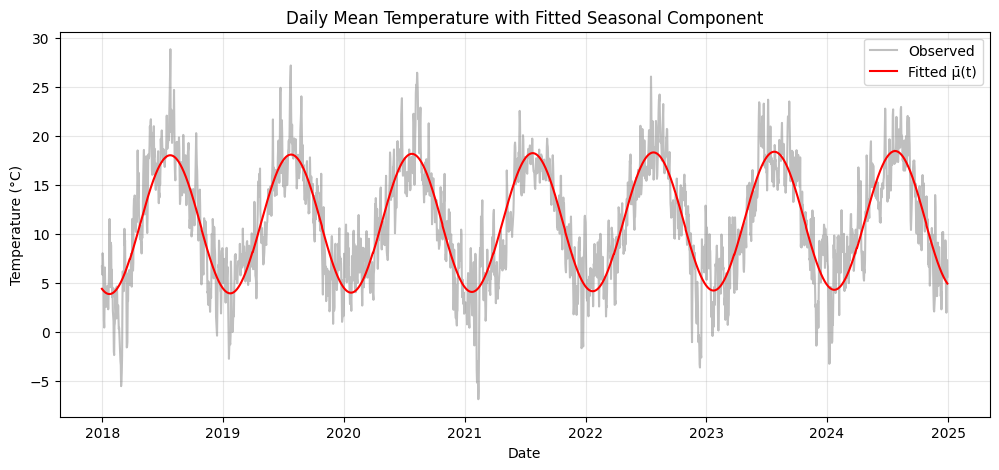

<Figure size 1200x600 with 0 Axes>

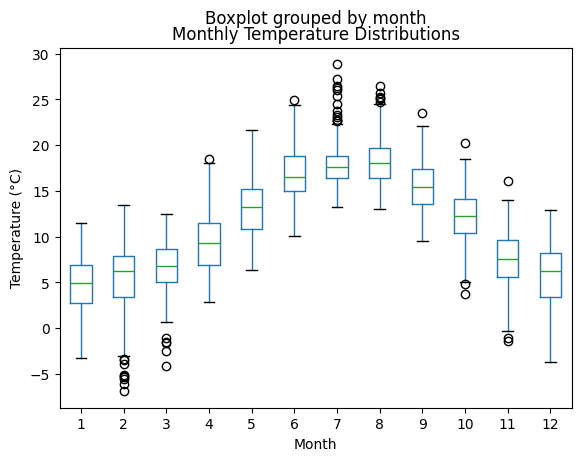

In [11]:
# Plot 1: Raw data with fitted seasonal mean
plt.figure(figsize=(12,5))
t = (df.index - df.index[0]).days.to_numpy()
plt.plot(df.index, df["T_mean"], 'gray', alpha=0.5, label="Observed")
plt.plot(df.index, model.mu_bar(t), 'r', label="Fitted μ̄(t)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Daily Mean Temperature with Fitted Seasonal Component")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/temp_seasonal_fit.png')

# Plot 2: Monthly temperature distributions
plt.figure(figsize=(12,6))
df_monthly = df.copy()
df_monthly['month'] = df_monthly.index.month
df_monthly.boxplot(column='T_mean', by='month', grid=False)
plt.title("Monthly Temperature Distributions")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.savefig('plots/monthly_temp_dist.png')
plt.show()

Now we'll price several HDD options and analyze their characteristics.

In [13]:
# Price three different contract designs
n_paths = 100_000

# 1. ATM Call
price_atm, se_atm, hit_cap_atm = price_hdd_call(
    model, n_paths=n_paths,
    strike=800, cap=4000,
    antithetic=True
)

# 2. OTM Call
price_otm, se_otm, hit_cap_otm = price_hdd_call(
    model, n_paths=n_paths,
    strike=1000, cap=5000,
    antithetic=True
)

# 3. Zero-Premium Collar
price_collar, se_collar, hit_cap_collar, hit_floor_collar = price_hdd_collar(
    model, n_paths=n_paths,
    strike_call=800, cap_call=4000,
    strike_put=750, floor_put=2000,
    antithetic=True
)

print("\nOption Pricing Results:")
print(f"ATM Call (K=800, C=4000):")
print(f"  Price = €{price_atm:.2f} ± {1.96*se_atm:.2f}")
print(f"  Cap hit probability: {hit_cap_atm:.1%}")

print(f"\nOTM Call (K=1000, C=5000):")
print(f"  Price = €{price_otm:.2f} ± {1.96*se_otm:.2f}")
print(f"  Cap hit probability: {hit_cap_otm:.1%}")

print(f"\nCollar (Kc=800/C=4000, Kp=750/F=2000):")
print(f"  Price = €{price_collar:.2f} ± {1.96*se_collar:.2f}")
print(f"  Call cap hit: {hit_cap_collar:.1%}")
print(f"  Put floor hit: {hit_floor_collar:.1%}")


Option Pricing Results:
ATM Call (K=800, C=4000):
  Price = €3002.04 ± 9.83
  Cap hit probability: 67.0%

OTM Call (K=1000, C=5000):
  Price = €2723.92 ± 14.01
  Cap hit probability: 42.2%

Collar (Kc=800/C=4000, Kp=750/F=2000):
  Price = €2778.56 ± 10.51
  Call cap hit: 67.0%
  Put floor hit: 8.8%


Finally, let's visualize the distribution of simulated HDD values.

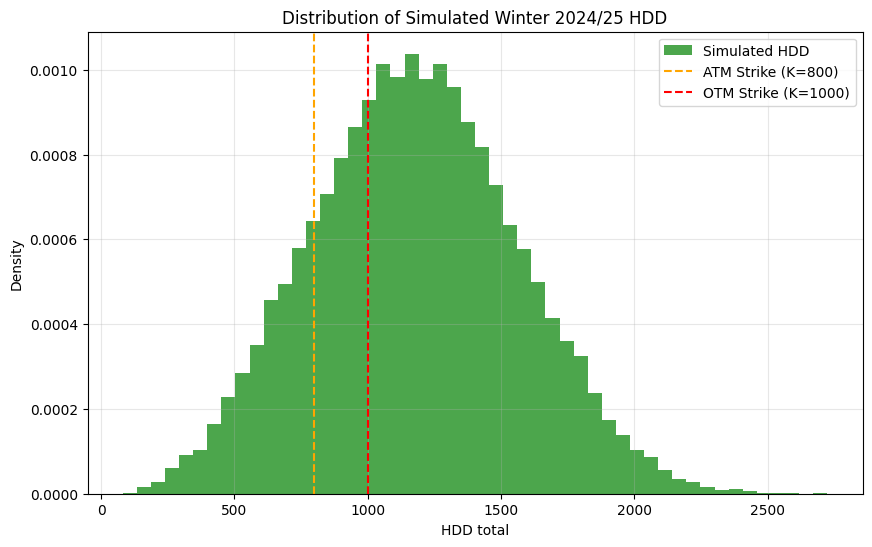

In [14]:
# Generate paths for winter 2024/25
paths = model.simulate_paths(20000, antithetic=True)
H = hdd_series(paths)

plt.figure(figsize=(10,6))
plt.hist(H, bins=50, density=True, alpha=0.7, color='green', 
         label="Simulated HDD")
plt.axvline(800, color="orange", ls="--", label="ATM Strike (K=800)")
plt.axvline(1000, color="red", ls="--", label="OTM Strike (K=1000)")
plt.xlabel("HDD total")
plt.ylabel("Density")
plt.title("Distribution of Simulated Winter 2024/25 HDD")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/hdd_distribution.png')
plt.show()

Let's examine how the price estimates converge with increasing sample size.


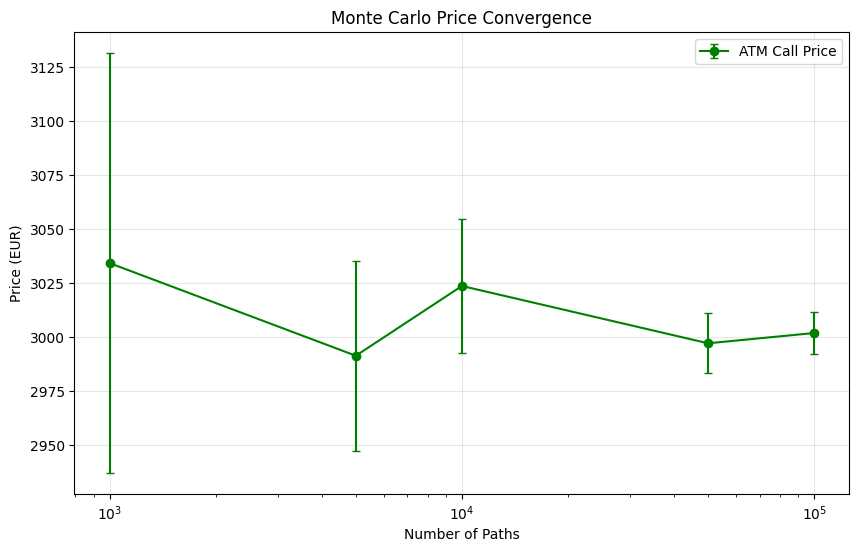

In [15]:
n_trials = [1000, 5000, 10000, 50000, 100000]
prices_atm = []
se_atm = []

for n in n_trials:
    p, se, _ = price_hdd_call(model, n_paths=n, strike=800, cap=4000,
                             antithetic=True)
    prices_atm.append(p)
    se_atm.append(se)

plt.figure(figsize=(10,6))
plt.errorbar(n_trials, prices_atm, yerr=[1.96*np.array(se_atm)]*2,
             fmt="o-", capsize=3, color='green', label='ATM Call Price')
plt.xscale("log")
plt.xlabel("Number of Paths")
plt.ylabel("Price (EUR)")
plt.title("Monte Carlo Price Convergence")
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('plots/convergence_analysis.png')
plt.show()